# CA1 Semester 2 - Advanced Data Analytics and Big Data integrated assessment

# Gavin Davis, sba22311, MSc_DA_PT

This notebook contains the code for processing knock airport weather data using apache spark to highlight how it can be used for big data processing. Following this the data was converted to a pandas dataframe and used to generate a model which could accurately predict temperature at knock airport. This code file accompanies a report file which discusses the relevant background, results and literature connected with this project.

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

# Section 1 - Data processing with pyspark

In [2]:
# A tutorial for this file is available at www.relataly.com

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean, to_timestamp
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Create my_spark
spark = SparkSession.builder.getOrCreate()
print(spark)

In [3]:
import pandas as pd
from datetime import datetime
import time

In [4]:
spark_weather_df_a = spark.read \
    .option("header", False) \
    .option("sep", ",") \
    .option("inferSchema", True) \
    .csv(path=f'/user1/knock_airport_data.csv')
    
spark_weather_df_a.printSchema()
spark_weather_df_a.describe().show()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)



+-------+----------------+-------------------+-------------------+--------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+
|summary|             _c0|                _c1|                _c2|                 _c3|              _c4|                _c5|               _c6|               _c7|               _c8|               _c9|              _c10|               _c11|             _c12|               _c13|              _c14|              _c15|             _c16|               _c17|              _c18|              _c19|              _c20|
+-------+----------------+-------------------+-------------------+--------------------+-----------------+-------------------+------------------+------------------+-------------

In [5]:
spark_weather_df_a = spark_weather_df_a.drop("_c12", "_c13", "_c14", "_c15", "_c16", "_c17", "_c18", "_c19")
spark_weather_df_a = spark_weather_df_a.drop("_c1","_c6", "_c7","_c8", "_c9","_c10", "_c11", "_c20")

In [6]:
spark_weather_df_a_renamed = spark_weather_df_a.withColumnRenamed("_c0", "date") \
    .withColumnRenamed("_c2", "rain") \
    .withColumnRenamed("_c4", "temp") 

In [7]:
spark_weather_df_a_renamed = spark_weather_df_a_renamed.drop("_c3","_c5")

In [8]:
spark_weather_df_a_renamed.printSchema()
spark_weather_df_a_renamed.describe().show()

root
 |-- date: string (nullable = true)
 |-- rain: string (nullable = true)
 |-- temp: string (nullable = true)



+-------+----------------+-------------------+-----------------+
|summary|            date|               rain|             temp|
+-------+----------------+-------------------+-----------------+
|  count|          233011|             233011|           233011|
|   mean|            null|0.15607161713763876|8.690509849362934|
| stddev|            null| 0.5073723927645681|4.607825558476559|
|    min|01/01/1997 00:00|                   |             -0.1|
|    max|            date|               rain|             temp|
+-------+----------------+-------------------+-----------------+



In [9]:
spark_weather_df_a_renamed = spark_weather_df_a_renamed.withColumn("rain",spark_weather_df_a_renamed.rain.cast(DoubleType()))
spark_weather_df_a_renamed.printSchema()

root
 |-- date: string (nullable = true)
 |-- rain: double (nullable = true)
 |-- temp: string (nullable = true)



In [10]:
spark_weather_df_a_renamed = spark_weather_df_a_renamed.withColumn("temp",spark_weather_df_a_renamed.temp.cast(DoubleType()))
spark_weather_df_a_renamed.printSchema()

root
 |-- date: string (nullable = true)
 |-- rain: double (nullable = true)
 |-- temp: double (nullable = true)



In [11]:
#Assessing the schema and descriptive stats of the dataframe

spark_weather_df_a_renamed.printSchema()
spark_weather_df_a_renamed.describe().show()

root
 |-- date: string (nullable = true)
 |-- rain: double (nullable = true)
 |-- temp: double (nullable = true)



+-------+----------------+-------------------+-----------------+
|summary|            date|               rain|             temp|
+-------+----------------+-------------------+-----------------+
|  count|          233011|             232961|           233010|
|   mean|            null|0.15607161713763876|8.690509849362934|
| stddev|            null| 0.5073723927645681|4.607825558476559|
|    min|01/01/1997 00:00|                0.0|             -6.9|
|    max|            date|               18.7|             28.5|
+-------+----------------+-------------------+-----------------+



In [12]:
#Creating a test df

spark_weather_df_a_renamed_test = spark_weather_df_a_renamed

In [13]:
#Converting the date column from string type to timestamp type

spark_weather_df_a_renamed_test.withColumn("timestamp",to_date("date")) \
  .show(truncate=False)


+----------------+----+----+---------+
|date            |rain|temp|timestamp|
+----------------+----+----+---------+
|date            |null|null|null     |
|10/04/1996 14:00|0.0 |11.5|null     |
|31/07/1996 08:00|0.0 |11.5|null     |
|31/07/1996 09:00|0.0 |11.6|null     |
|31/07/1996 10:00|0.0 |12.9|null     |
|31/07/1996 11:00|0.0 |14.5|null     |
|31/07/1996 12:00|0.0 |14.4|null     |
|31/07/1996 13:00|0.0 |14.9|null     |
|31/07/1996 14:00|0.0 |13.9|null     |
|31/07/1996 15:00|0.0 |13.2|null     |
|31/07/1996 16:00|0.0 |15.1|null     |
|31/07/1996 17:00|0.0 |11.6|null     |
|31/07/1996 18:00|0.0 |13.3|null     |
|31/07/1996 19:00|0.0 |12.7|null     |
|31/07/1996 20:00|0.0 |11.5|null     |
|31/07/1996 21:00|0.0 |10.9|null     |
|31/07/1996 22:00|0.0 |10.8|null     |
|31/07/1996 23:00|0.0 |9.6 |null     |
|01/08/1996 00:00|0.0 |9.7 |null     |
|01/08/1996 01:00|0.0 |9.1 |null     |
+----------------+----+----+---------+
only showing top 20 rows



In [14]:
#Checking the schema and the descriptive stats of the dataframe

spark_weather_df_a_renamed_test.printSchema()
spark_weather_df_a_renamed_test.describe().show()

root
 |-- date: string (nullable = true)
 |-- rain: double (nullable = true)
 |-- temp: double (nullable = true)



+-------+----------------+-------------------+-----------------+
|summary|            date|               rain|             temp|
+-------+----------------+-------------------+-----------------+
|  count|          233011|             232961|           233010|
|   mean|            null|0.15607161713763876|8.690509849362934|
| stddev|            null| 0.5073723927645681|4.607825558476559|
|    min|01/01/1997 00:00|                0.0|             -6.9|
|    max|            date|               18.7|             28.5|
+-------+----------------+-------------------+-----------------+



In [15]:
#Dropping the unnecessary timestamp column

spark_weather_df_a_renamed_test = spark_weather_df_a_renamed_test.drop("timestamp")

In [16]:
#Visualising the dataframe

spark_weather_df_a_renamed_test.show(20)

+----------------+----+----+
|            date|rain|temp|
+----------------+----+----+
|            date|null|null|
|10/04/1996 14:00| 0.0|11.5|
|31/07/1996 08:00| 0.0|11.5|
|31/07/1996 09:00| 0.0|11.6|
|31/07/1996 10:00| 0.0|12.9|
|31/07/1996 11:00| 0.0|14.5|
|31/07/1996 12:00| 0.0|14.4|
|31/07/1996 13:00| 0.0|14.9|
|31/07/1996 14:00| 0.0|13.9|
|31/07/1996 15:00| 0.0|13.2|
|31/07/1996 16:00| 0.0|15.1|
|31/07/1996 17:00| 0.0|11.6|
|31/07/1996 18:00| 0.0|13.3|
|31/07/1996 19:00| 0.0|12.7|
|31/07/1996 20:00| 0.0|11.5|
|31/07/1996 21:00| 0.0|10.9|
|31/07/1996 22:00| 0.0|10.8|
|31/07/1996 23:00| 0.0| 9.6|
|01/08/1996 00:00| 0.0| 9.7|
|01/08/1996 01:00| 0.0| 9.1|
+----------------+----+----+
only showing top 20 rows



In [17]:
#Creating a test df

spark_weather_df_a_renamed_test_1 = spark_weather_df_a_renamed_test

In [18]:
#Dropping the first row with null values

spark_weather_df_a_renamed_test_1.na.drop(subset=["rain","temp"]) \
    .show(truncate=False)

+----------------+----+----+
|date            |rain|temp|
+----------------+----+----+
|10/04/1996 14:00|0.0 |11.5|
|31/07/1996 08:00|0.0 |11.5|
|31/07/1996 09:00|0.0 |11.6|
|31/07/1996 10:00|0.0 |12.9|
|31/07/1996 11:00|0.0 |14.5|
|31/07/1996 12:00|0.0 |14.4|
|31/07/1996 13:00|0.0 |14.9|
|31/07/1996 14:00|0.0 |13.9|
|31/07/1996 15:00|0.0 |13.2|
|31/07/1996 16:00|0.0 |15.1|
|31/07/1996 17:00|0.0 |11.6|
|31/07/1996 18:00|0.0 |13.3|
|31/07/1996 19:00|0.0 |12.7|
|31/07/1996 20:00|0.0 |11.5|
|31/07/1996 21:00|0.0 |10.9|
|31/07/1996 22:00|0.0 |10.8|
|31/07/1996 23:00|0.0 |9.6 |
|01/08/1996 00:00|0.0 |9.7 |
|01/08/1996 01:00|0.0 |9.1 |
|01/08/1996 02:00|0.0 |10.0|
+----------------+----+----+
only showing top 20 rows



In [19]:
spark_weather_df_a_renamed_test_1.show(5)

+----------------+----+----+
|            date|rain|temp|
+----------------+----+----+
|            date|null|null|
|10/04/1996 14:00| 0.0|11.5|
|31/07/1996 08:00| 0.0|11.5|
|31/07/1996 09:00| 0.0|11.6|
|31/07/1996 10:00| 0.0|12.9|
+----------------+----+----+
only showing top 5 rows



In [20]:
spark_weather_df_a_renamed_test_2 = spark_weather_df_a_renamed_test_1.na.drop()

In [21]:
spark_weather_df_a_renamed_test_2.show(5)

+----------------+----+----+
|            date|rain|temp|
+----------------+----+----+
|10/04/1996 14:00| 0.0|11.5|
|31/07/1996 08:00| 0.0|11.5|
|31/07/1996 09:00| 0.0|11.6|
|31/07/1996 10:00| 0.0|12.9|
|31/07/1996 11:00| 0.0|14.5|
+----------------+----+----+
only showing top 5 rows



In [22]:
print((spark_weather_df_a_renamed_test_1.count(), len(spark_weather_df_a_renamed_test_1.columns)))

(233011, 3)


In [23]:
#Assessing the shape of the cleaned dataframe

print((spark_weather_df_a_renamed_test_2.count(), len(spark_weather_df_a_renamed_test_2.columns)))

(232961, 3)


In [24]:
spark_weather_df_a_renamed_test_1.show(5)

+----------------+----+----+
|            date|rain|temp|
+----------------+----+----+
|            date|null|null|
|10/04/1996 14:00| 0.0|11.5|
|31/07/1996 08:00| 0.0|11.5|
|31/07/1996 09:00| 0.0|11.6|
|31/07/1996 10:00| 0.0|12.9|
+----------------+----+----+
only showing top 5 rows



In [25]:
def quick_overview(df):
   # display the spark dataframe
   print("FIRST RECORDS")
   print(df.limit(2).sort(col("date"), ascending=True).toPandas())

   # count null values
   print("COUNT NULL VALUES")
   print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in df.dtypes if y in ["double", "float"]]
      ).toPandas())

   print("DESCRIBE STATISTICS")
   print(df.describe().toPandas())
   # # Alternatively to get the max value, we could use max_value = df.agg({"precipitation": "max"}).collect()[0][0]

   # check for dublicates
   dublicates = df.groupby(df.date) \
    .count() \
    .where('count > 1') \
    .limit(5).toPandas()
   print(dublicates)

   # print schema
   print("PRINT SCHEMA")
   print(df.printSchema())

quick_overview(spark_weather_df_a_renamed_test_2)

FIRST RECORDS
               date  rain  temp
0  10/04/1996 14:00   0.0  11.5
1  31/07/1996 08:00   0.0  11.5
COUNT NULL VALUES


   rain  temp
0     0     0
DESCRIBE STATISTICS


  summary              date                 rain               temp
0   count            232961               232961             232961
1    mean              None  0.15607161713763876  8.690736646906807
2  stddev              None   0.5073723927645681   4.60804223826037
3     min  01/01/1997 00:00                  0.0               -6.9
4     max  31/12/2022 23:00                 18.7               28.5


Empty DataFrame
Columns: [date, count]
Index: []
PRINT SCHEMA
root
 |-- date: string (nullable = true)
 |-- rain: double (nullable = true)
 |-- temp: double (nullable = true)

None


In [26]:
new_df = spark_weather_df_a_renamed_test_2.toPandas()

In [27]:
new_df

,date,rain,temp
0,10/04/1996 14:00,0.0,11.5
1,31/07/1996 08:00,0.0,11.5
2,31/07/1996 09:00,0.0,11.6
3,31/07/1996 10:00,0.0,12.9
4,31/07/1996 11:00,0.0,14.5
...,...,...,...
232956,28/02/2023 20:00,0.0,3.9
232957,28/02/2023 21:00,0.0,3.7
232958,28/02/2023 22:00,0.0,3.7
232959,28/02/2023 23:00,0.0,3.7


In [28]:
new_df.dtypes

date     object
rain    float64
temp    float64
dtype: object

In [29]:
new_df['date'] = pd.to_datetime(new_df['date'])

In [30]:
new_df['date']

0        1996-10-04 14:00:00
1        1996-07-31 08:00:00
2        1996-07-31 09:00:00
3        1996-07-31 10:00:00
4        1996-07-31 11:00:00
                 ...        
232956   2023-02-28 20:00:00
232957   2023-02-28 21:00:00
232958   2023-02-28 22:00:00
232959   2023-02-28 23:00:00
232960   2023-01-03 00:00:00
Name: date, Length: 232961, dtype: datetime64[ns]

In [31]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232961 entries, 0 to 232960
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    232961 non-null  datetime64[ns]
 1   rain    232961 non-null  float64       
 2   temp    232961 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.3 MB


In [32]:
df = new_df

# Section 2 - Data visualisation

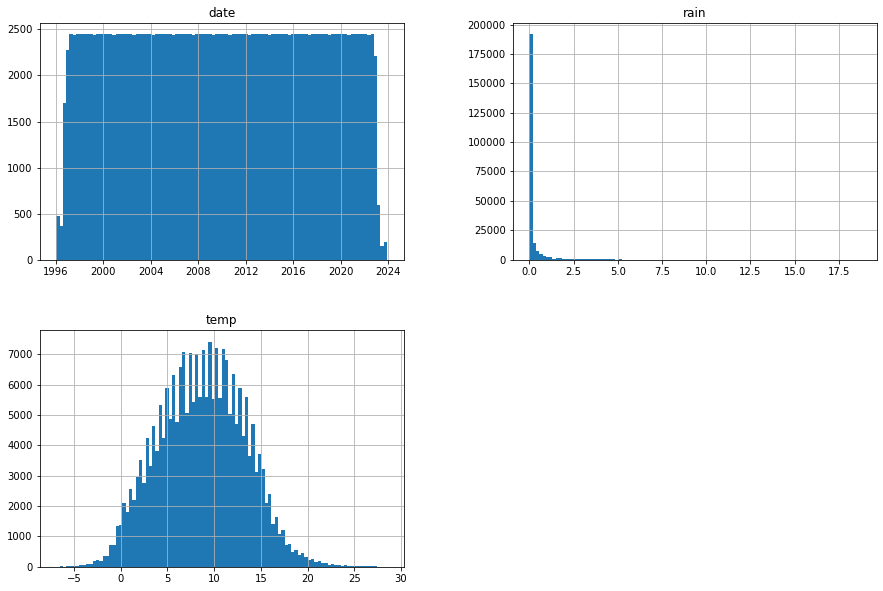

In [33]:
df.hist(figsize=(15,10), bins=100);

<function matplotlib.pyplot.show(close=None, block=None)>

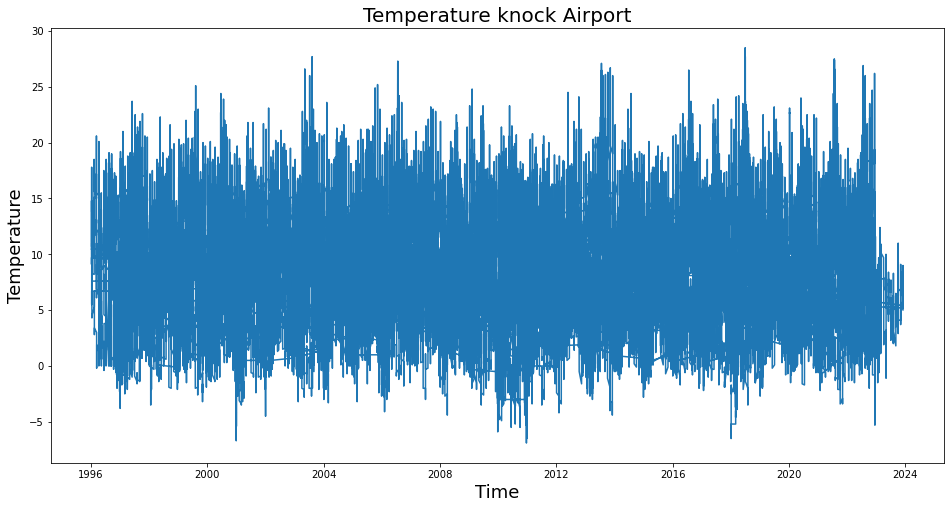

In [34]:
plt.figure(figsize=(16,8))
plt.title('Temperature knock Airport',fontsize=20)
plt.plot(df['date'], df['temp'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

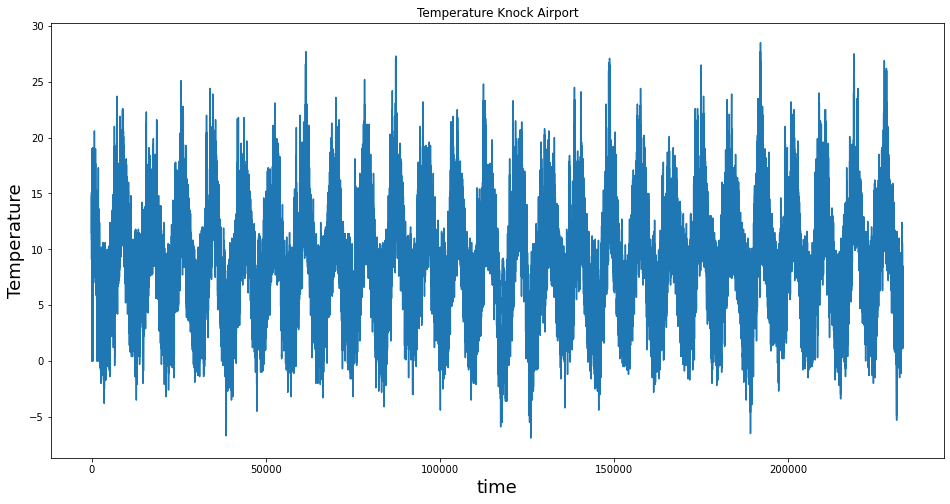

In [35]:
plt.figure(figsize=(16,8))
plt.title('Temperature Knock Airport')
plt.plot(df['temp'])
plt.xlabel('time', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.show

# Section 3 - LSTM Implementation

In [36]:
data =df.filter(['temp'])

In [37]:
data

,temp
0,11.5
1,11.5
2,11.6
3,12.9
4,14.5
...,...
232956,3.9
232957,3.7
232958,3.7
232959,3.7


In [38]:
dataset = data.values

In [39]:
dataset

array([[11.5],
       [11.5],
       [11.6],
       ...,
       [ 3.7],
       [ 3.7],
       [ 3.7]])

In [40]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import time
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

2023-04-12 11:46:41.115169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 11:46:41.516302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 11:46:41.517369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 11:46:43.263612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [41]:
training_data_len = math.ceil( len(dataset) * .8 )

In [42]:
training_data_len 

186369

In [43]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [44]:
dataset

array([[0.51977401],
       [0.51977401],
       [0.52259887],
       ...,
       [0.29943503],
       [0.29943503],
       [0.29943503]])

In [45]:
train_data = dataset[0:training_data_len , :]

In [46]:
x_train =[]
y_train =[]

In [47]:
for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i,0])
    y_train.append(train_data[i,0])

In [48]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [49]:
x_train =np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(186339, 30, 1)

In [50]:
from keras.layers import LSTM,Dense ,Dropout

In [51]:
model = Sequential()
model.add(LSTM(100, return_sequences = True,activation='relu', input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100,activation='relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dense(1))

In [52]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [53]:
model.fit(x_train, y_train, batch_size = 365, epochs = 10)

Epoch 1/10


2023-04-12 11:47:08.595784: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22360680 exceeds 10% of free system memory.


511/511 [==============================] - 122s 234ms/step - loss: 0.0046
Epoch 2/10
511/511 [==============================] - 117s 229ms/step - loss: 0.0011
Epoch 3/10
511/511 [==============================] - 118s 231ms/step - loss: 7.8491e-04
Epoch 4/10
511/511 [==============================] - 117s 228ms/step - loss: 6.6584e-04
Epoch 5/10
511/511 [==============================] - 116s 227ms/step - loss: 6.1028e-04
Epoch 6/10
511/511 [==============================] - 116s 228ms/step - loss: 5.7167e-04
Epoch 7/10
511/511 [==============================] - 115s 225ms/step - loss: 5.5502e-04
Epoch 8/10
511/511 [==============================] - 120s 235ms/step - loss: 5.4637e-04
Epoch 9/10
511/511 [==============================] - 119s 233ms/step - loss: 5.3362e-04
Epoch 10/10
511/511 [==============================] - 117s 229ms/step - loss: 5.2470e-04


In [54]:
test_data = dataset[training_data_len -30: , :]

In [55]:
x_test = []
y_test = dataset[training_data_len:, :]

In [56]:
  for i in range(30,len(test_data)):
    x_test.append(test_data[i-30:i, 0])

In [57]:
x_test = np.array(x_test)

In [58]:
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [59]:
predictions = model.predict(x_test)

1456/1456 [==============================] - 36s 24ms/step


In [60]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# Mean square error
print_error(y_train, y_test, train_predict, test_predict)

2023-04-12 12:07:48.585359: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22360680 exceeds 10% of free system memory.


1456/1456 [==============================] - 35s 24ms/step
Train RMSE: 0.023 RMSE
Test RMSE: 0.023 RMSE


In [61]:
predictions = scaler.inverse_transform(predictions)

In [62]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),predictions))
r2_value = r2_score(scaler.inverse_transform(y_test),predictions)

In [63]:
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  0.8226507590368027
R^2 Value:  0.9696108330055491


In [64]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/tmp/ipykernel_3818/2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


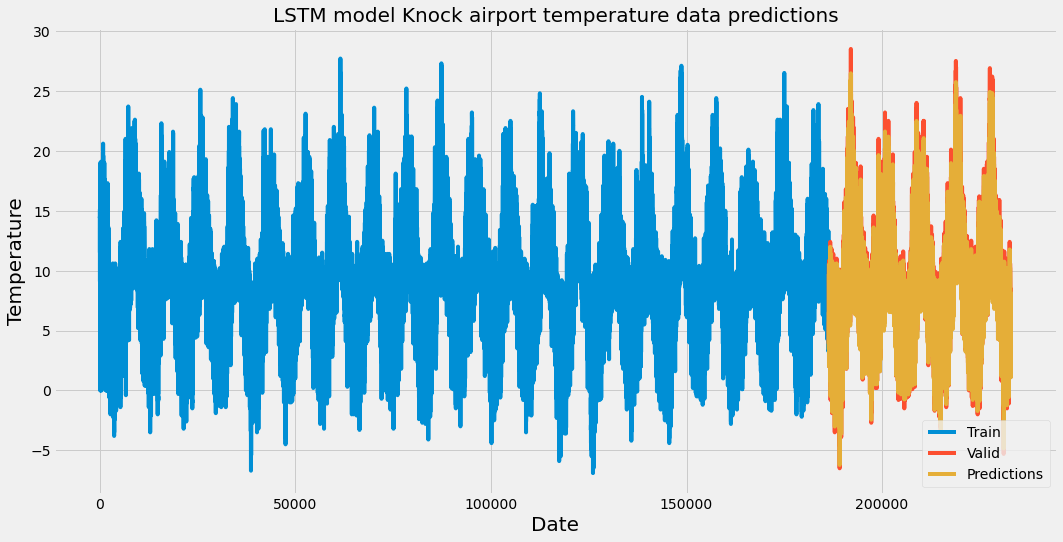

In [65]:
plt.figure(figsize=(16,8))
plt.title('LSTM model Knock airport temperature data predictions',fontsize=20 )
plt.xlabel('Date',fontsize=20)
plt.ylabel('Temperature', fontsize=20)
plt.plot(train['temp'])
plt.plot(valid[['temp', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

In [66]:
temp_pred = pd.read_csv('knock_airport_data.csv')

/tmp/ipykernel_3818/3624882616.py:1: DtypeWarning: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_pred = pd.read_csv('knock_airport_data.csv')


In [67]:
new_df = temp_pred['temp']

In [68]:
t1 = new_df.tail(30)

In [69]:
t1.mean()

4.180000000000001

In [70]:
last_30_days = new_df[-30:].values

In [71]:
last_30_days

array([4.7, 4.4, 4.2, 3.9, 3.8, 3.7, 3.6, 3.5, 3.1, 3. , 3.3, 2.8, 2.8,
       3.5, 3.8, 4.2, 5.2, 5.8, 6.1, 5.9, 6.1, 5.2, 5.1, 4.7, 4.3, 3.9,
       3.7, 3.7, 3.7, 3.7])

In [72]:
last_30_days_scaled = scaler.transform(last_30_days.reshape(-1, 1))

#### plt.plot(last_30_days)

In [74]:
X_test2 = []

In [75]:
X_test2.append(last_30_days_scaled)

In [76]:
X_test2 = np.array(X_test2)

In [77]:
X_test2 = np.reshape(X_test2,(X_test2.shape[0],X_test2.shape[1], 1))

In [78]:
X_test2.shape

(1, 30, 1)

In [79]:
pred_temp = model.predict(X_test2)

1/1 [==============================] - 0s 82ms/step


In [80]:
pred_temp = scaler.inverse_transform(pred_temp)
print('The predicted temperature on the last day: ', pred_temp) 

The predicted temperature on the last day:  [[3.4506793]]


Text(0, 0.5, 'Temperature')

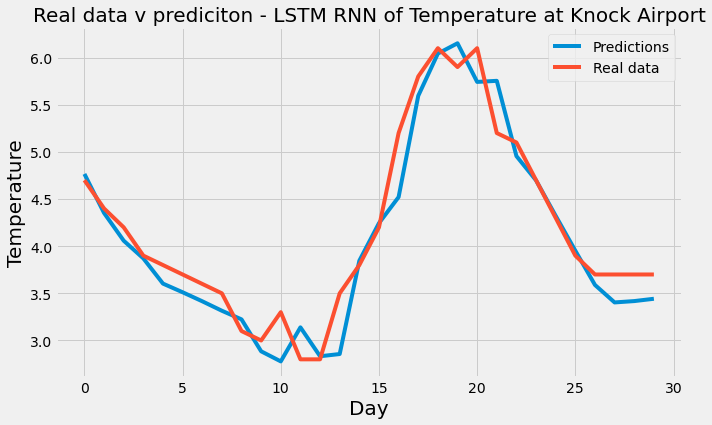

In [81]:
plt.figure(figsize=(10,6))
plt.plot(predictions[-30:], label = 'Predictions')
plt.plot(last_30_days, label = 'Real data')
plt.legend()
plt.title('Real data v prediciton - LSTM RNN of Temperature at Knock Airport', fontsize=20);
plt.xlabel('Day', fontsize=20)
plt.ylabel('Temperature', fontsize=20)

# Section 4 - Simple RNN implementation

In [82]:
from keras.layers import Dense, SimpleRNN

In [83]:
model = Sequential()
model.add(SimpleRNN(100, input_shape=(x_train.shape[1], 1), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
    
 
model.fit(x_train, y_train, batch_size = 365, epochs=10)

Epoch 1/10


2023-04-12 12:12:52.165384: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22360680 exceeds 10% of free system memory.


511/511 [==============================] - 30s 56ms/step - loss: 0.0014
Epoch 2/10
511/511 [==============================] - 30s 59ms/step - loss: 3.2986e-04
Epoch 3/10
511/511 [==============================] - 30s 59ms/step - loss: 3.2142e-04
Epoch 4/10
511/511 [==============================] - 31s 60ms/step - loss: 3.1828e-04
Epoch 5/10
511/511 [==============================] - 31s 61ms/step - loss: 3.1665e-04
Epoch 6/10
511/511 [==============================] - 31s 60ms/step - loss: 3.1590e-04
Epoch 7/10
511/511 [==============================] - 30s 59ms/step - loss: 3.1504e-04
Epoch 8/10
511/511 [==============================] - 30s 58ms/step - loss: 3.1430e-04
Epoch 9/10
511/511 [==============================] - 30s 59ms/step - loss: 3.1189e-04
Epoch 10/10
511/511 [==============================] - 30s 59ms/step - loss: 3.0863e-04


In [84]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# Mean square error
print_error(y_train, y_test, train_predict, test_predict)

2023-04-12 12:18:15.428126: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22360680 exceeds 10% of free system memory.


1456/1456 [==============================] - 14s 10ms/step
Train RMSE: 0.018 RMSE
Test RMSE: 0.017 RMSE


In [86]:
test_data = dataset[training_data_len -30: , :]

In [87]:
x_test = []
y_test = dataset[training_data_len:, :]

In [88]:
  for i in range(30,len(test_data)):
    x_test.append(test_data[i-30:i, 0])

In [89]:
x_test = np.array(x_test)

In [90]:
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [91]:
predictions = model.predict(x_test)

1456/1456 [==============================] - 15s 10ms/step


In [92]:
predictions = scaler.inverse_transform(predictions)

In [93]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),predictions))
r2_value = r2_score(scaler.inverse_transform(y_test),predictions)

In [94]:
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  0.6186143073156399
R^2 Value:  0.9828158636315121


In [95]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/tmp/ipykernel_3818/2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


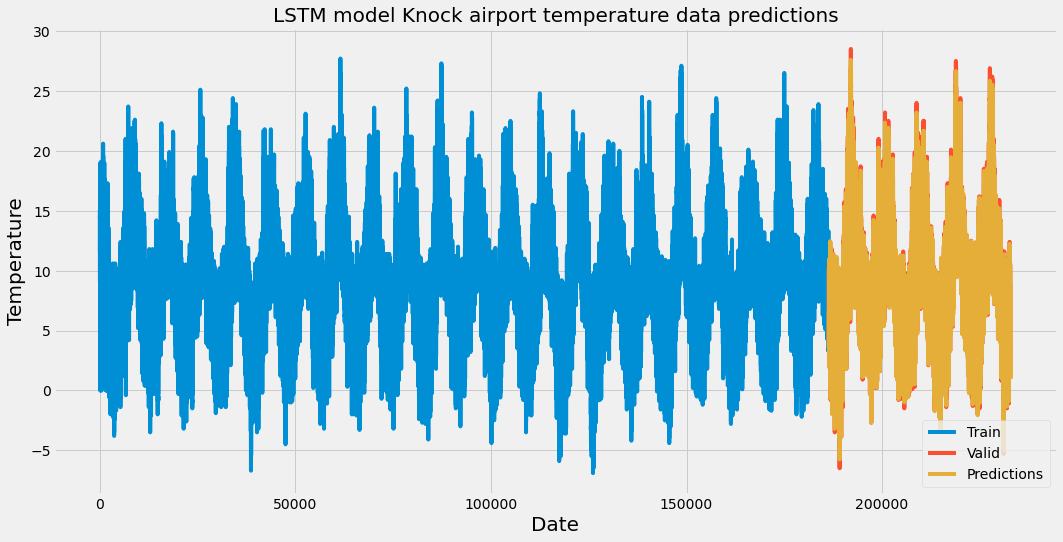

In [96]:
plt.figure(figsize=(16,8))
plt.title('LSTM model Knock airport temperature data predictions',fontsize=20 )
plt.xlabel('Date',fontsize=20)
plt.ylabel('Temperature', fontsize=20)
plt.plot(train['temp'])
plt.plot(valid[['temp', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

In [97]:
temp_pred = pd.read_csv('knock_airport_data.csv')

/tmp/ipykernel_3818/3624882616.py:1: DtypeWarning: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_pred = pd.read_csv('knock_airport_data.csv')


In [98]:
new_df = temp_pred['temp']

In [99]:
last_30_days = new_df[-30:].values

In [100]:
last_30_days_scaled = scaler.transform(last_30_days.reshape(-1, 1))

In [101]:
X_test2 = []

In [102]:
X_test2.append(last_30_days_scaled)

In [103]:
X_test2 = np.array(X_test2)

In [104]:
X_test2 = np.reshape(X_test2,(X_test2.shape[0],X_test2.shape[1], 1))

In [105]:
X_test2.shape

(1, 30, 1)

In [106]:
pred_temp = model.predict(X_test2)

1/1 [==============================] - 0s 39ms/step


In [107]:
pred_temp = scaler.inverse_transform(pred_temp)
print('The predicted temperature on the last day: ', pred_temp) 

The predicted temperature on the last day:  [[3.5561364]]


Text(0, 0.5, 'Temperature')

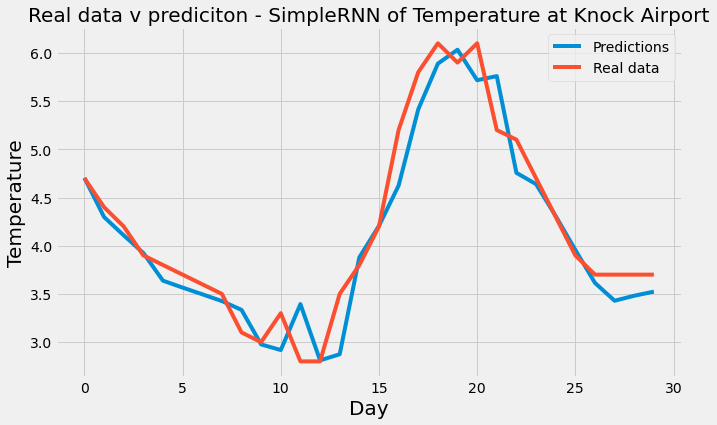

2023-04-14 10:10:43,396 WARN spark.HeartbeatReceiver: Removing executor driver with no recent heartbeats: 370825 ms exceeds timeout 120000 ms
2023-04-14 10:10:43,432 WARN spark.SparkContext: Killing executors is not supported by current scheduler.


In [109]:
plt.figure(figsize=(10,6))
plt.plot(predictions[-30:], label = 'Predictions')
plt.plot(last_30_days, label = 'Real data')
plt.legend()
plt.title('Real data v prediciton - SimpleRNN of Temperature at Knock Airport', fontsize=20);
plt.xlabel('Day', fontsize=20)
plt.ylabel('Temperature', fontsize=20)

# END OF FILE